In [1]:
%matplotlib inline

## Methodology

This document records a fault detection of zone CO2 balance using Extended Kalman Filter (EKF). EKF provides possitiblities for recursive parameter and state estimations.

CO2 balance is a good candidate for zone level FDD due to the fact that CO2 level is often not controlled, making this a open loop process, and output problems caused by faults are often more observable than closed loop systems (zone thermal performance). Also inputs and parameters to this process is much less, making the EKF implementation more stable.

Assume the room, outdoor and HVAC air pressures are at equilibrium and ingnore interzone air flows. By using mass balance, the concentration of indoor CO2 is goverened by:
$$ dC_{room} = (C_{out}-C_{room})\frac{\dot{q}_{infil}}{V_{room}} + (C_{supply}-C_{room})\frac{\dot{q}_{supply}}{V_{room}} + N_{occu}\frac{\dot{G}_{gen}}{V_{room}}$$


$C_{room}$, $C_{out}$ and $C_{supply}$ are the room, outdoor and supply air CO2 concentrations respectively. $\dot{q}_{infil}$ is the infiltration flow rate, $\dot{q}_{supply}$ is the supply air flow rate. $N_{occu}$ is the number of occupants and $\dot{G}_{gen}$ is the average CO2 generation rate of a person. $V_{room}$ is the volumn of the room.

Usually $C_{room}$, $C_{supply}$ and $Q_{supply}$ are measured, $C_{out}$ is available from the weather data. $\dot{G}_{gen}$ is known for typical office work at $0.25L/min$. $V_{room}$ is not usually available to a controller, unless BIM is integrated, which is assumed to be unavailable in this case. $\dot{q_{infil}}$ is usually unknown as well. $N_{occu}$ is usually unknown but state of occupancy $S_{occu}$ is typically available through occupancy sensor.

Then discretize the function, and adding some artificial parameter terms, we have:
$$C_{room,t+\Delta t} = C_{room,t} - C_{room,t}\frac{\dot{q_{infil,t}}\Delta t}{V_{room}} + C_{out,t}\frac{\dot{q_{infil,t}}\Delta t}{V_{room}} - C_{room,t}\dot{q}_{supply,t}\frac{\Delta t}{V_{room}} + C_{supply,t}\dot{q}_{supply,t}\frac{\Delta t}{V_{room}} + S_{occu,t}\frac{\dot{V}_{gen}N_{occu,t}\Delta t}{V_{room}}$$

Then the function can be further reduced to:
$$C_{room,t+\Delta t} = C_{room,t} - C_{room,t}p_{1,t} + C_{out,t}p_{1,t} - C_{room,t}\dot{q}_{supply,t}p_{2,t} + C_{supply,t}\dot{q}_{supply,t}p_{2,t} + S_{occu,t}p_{3,t}$$


The state and parameter extimate vector x, is:
$$ x = \left[\begin{array}
{r}
C_{room} \\
p_1 \\
p_2 \\
p_3
\end{array}\right]
= \left[\begin{array}
{r}
x_1 \\
x_2 \\
x_3 \\
x_4
\end{array}\right]$$

Input vector u, is:
$$ u = 
\left[\begin{array}
{r}
C_{out} \\
C_{supply} \\
\dot{q}_{supply} \\
S_{occu} \\
\end{array}\right]
= \left[\begin{array}
{r}
u_1 \\
u_2 \\
u_3 \\
u_4
\end{array}\right]
$$

## Filter Setup

The volumn of this room is $61.6 m^3$, and outdoor air CO2 concentration is assumed to be $420 ppm$ constant. The CO2 generation rate of the occupant is $3.82*10^{-6} m^3/s$. There is only one occupant and the infiltration rate is 1 ACH. Simulation timestep is 5 mins.

With a 5min timestep, the theoretical values for the parameters are:
$$ x = \left[\begin{array}
{r}
C_{room} \\
0.083 \\
4.867 \\
29.917
\end{array}\right]
$$

The EKF class is already created. All that need to do is to use sympy to create symbolic x, u vectors and the function vector so that the Jacobian matrix inside the EKF can be calculated automatically.

Another advantage to use sympy is that it can 'lambdify' its functions, so the substitution and matrix manipulation can be calculated very efficiently.

In [2]:
import numpy as np
import sympy
import library.EKF as EKF
import pandas as pd

In [3]:
#Creating sympy symbols
x1, x2, x3, x4, u1, u2, u3, u4 = sympy.symbols('x1 x2 x3 x4 u1 u2 u3 u4')
#Creating x and u vector, unlike numpy, sympy creates column vector automatically
X = sympy.Matrix([x1, x2, x3, x4])
U = sympy.Matrix([u1, u2, u3, u4])
print(X)

Matrix([[x1], [x2], [x3], [x4]])


In [4]:
#Set up the sympy function
fun = sympy.Matrix([
    x1 - x2*x1 + u1*x2 - x1*u3*x3 + u2*u3*x3 + u4*x4,
    x2,
    x3,
    x4
])
print(fun)

Matrix([[u1*x2 + u2*u3*x3 - u3*x1*x3 + u4*x4 - x1*x2 + x1], [x2], [x3], [x4]])


In [5]:
P = np.eye(4)
q = np.array([3.0, 0.0, 0.0, 0.0])[np.newaxis]
Q = q.T * q
print(Q)
#Measuremen covariance, values are very small for parameter estimates
R = np.matrix([[5,1,3,2],[0.002,0.001,0.003,0.002],[0.02,0.04,0.04,0.02],[0.01,0.02,0.02,0.05]])
H = sympy.Matrix([x1, 0, 0, 0])

[[ 9.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [6]:
#Import the data as a pandas dataframe
data = pd.read_csv('data/EP_CO2.csv')
#Initial conditions doesn't have to be precise
state_estimates = np.matrix([[data["ZoneCO2"][0]],
                             [0.08],
                             [5.0],
                             [30.3]])
co2_ekf = EKF.ExtendedKalmanFilter(fun, X, U, P, Q, H, R, state_estimates)

In [7]:
#Observe EKF Jacobian calculated using sympy
print(co2_ekf.F)

Matrix([[-u3*x3 - x2 + 1, u1 - x1, u2*u3 - u3*x1, u4], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])


In [8]:
#Try a first prediction
#generate control vector
C_out = 420
C_supply = data["SupplyCO2"][0]
Q_supply = data["SupplyFlow"][0]
OCC = data["OCCU"][0]
controls = np.matrix([[C_out], [C_supply], [Q_supply], [OCC]])
co2_ekf.predict(controls)
print(co2_ekf.X_values)

[[  4.20133074e+02]
 [  8.00000000e-02]
 [  5.00000000e+00]
 [  3.03000000e+01]]


## Experiment Setup

Sensor noise are also assumed and injected, CO2 sensors has a Gaussian noise with $10ppm$ std, and flow rate readings, typically coming from square root of a pressure reading and kfactor conversion, has a Gaussian noise with $0.001 m^3/s$.

In [9]:
predicted = []
actual = []
measured = []
estimates = []
p1 = []
p2 = []
p3 = []
length = data.shape[0]
iterations = length
#setting up sensor noises
np.random.seed(1234)
zoneCO2_noise = np.random.normal(0,10,iterations)
supplyCO2_noise = np.random.normal(0,10,iterations)
supplyflow_noise = np.random.normal(0,0.001,iterations)

In [10]:
for i in range(1, iterations):
    #generate control vector
    C_out = 420
    C_supply = data["SupplyCO2"][i-1] + supplyCO2_noise[i-1]
    Q_supply = data["SupplyFlow"][i-1] + supplyflow_noise[i-1]
    OCC = data["OCCU"][i-1]
    controls = np.matrix([[C_out], [C_supply], [Q_supply], [OCC]])

    #prediction
    co2_ekf.predict(controls)
    predicted.append(co2_ekf.X_values[0,0])
    estimates.append(co2_ekf.X_values.T.reshape(-1,).tolist())
    p1.append(co2_ekf.X_values[1,0])
    p2.append(co2_ekf.X_values[2,0])
    p3.append(co2_ekf.X_values[3,0])

    #update
    meas = data["ZoneCO2"][i] + zoneCO2_noise[i]
    actual.append(data["ZoneCO2"][i])
    measured.append(meas)
    co2_ekf.update(np.matrix([[meas],[0],[0],[0]]))

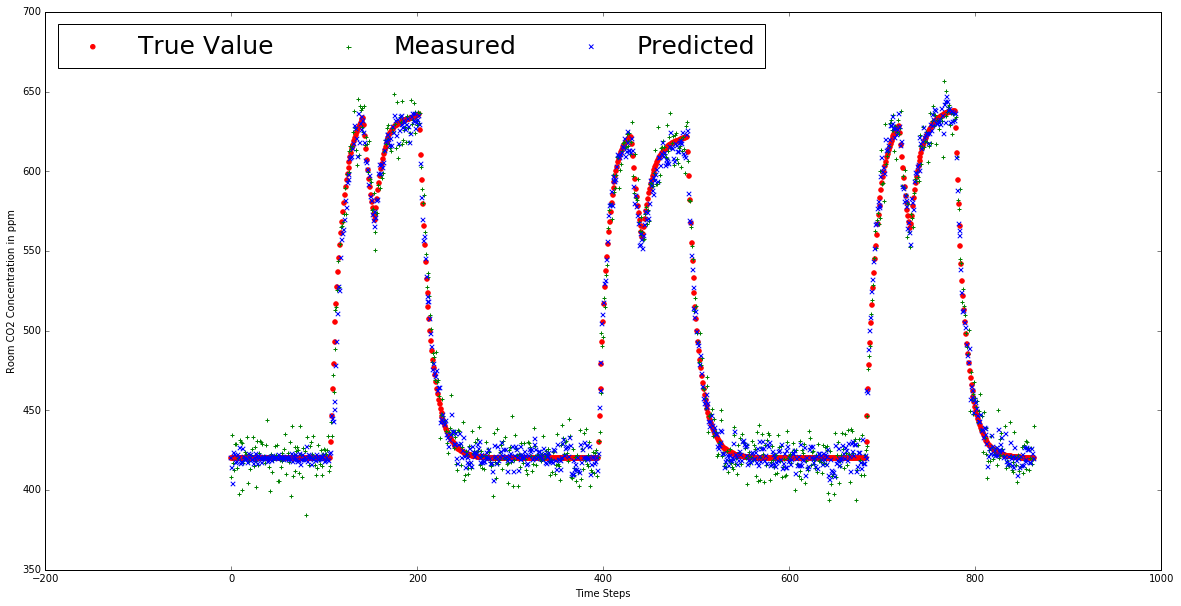

In [11]:
import matplotlib.pyplot as plt
#plotting first three days of prediction results
plot_len = (3*24*12)
x = np.arange(plot_len)
plt.figure(figsize=(20,10))
tru = plt.scatter(x, actual[0:plot_len], color="r", marker="o")
mea = plt.scatter(x, measured[0:plot_len], color="g", marker = "+")
pre = plt.scatter(x, predicted[0:plot_len], color="b", marker="x")
plt.legend((tru,mea,pre),
           ("True Value","Measured", "Predicted"),
            scatterpoints = 1,
            ncol = 3,
            fontsize=25,
            loc="upper left")
plt.xlabel("Time Steps")
plt.ylabel("Room CO2 Concentration in ppm")
plt.show()

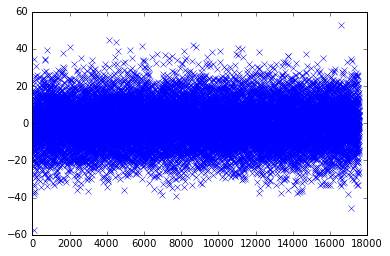

In [12]:
import operator
residues = list(map(operator.sub, predicted, measured))
plt.plot(residues, 'x')
plt.show()

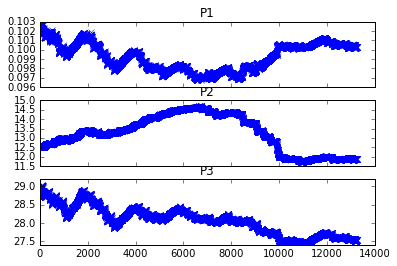

In [48]:
plot_start = 15*24*12
plot_end = iterations
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(p1[plot_start:plot_end],'x')
axarr[0].set_title('P1')
axarr[1].plot(p2[plot_start:plot_end],'x')
axarr[1].set_title('P2')
axarr[2].plot(p3[plot_start:plot_end],'x')
axarr[2].set_title('P3')

In [13]:
#after first 15 days of waiting for the data to stabilize, 
#use the rest of the 15 days to obtain normal operation parameters
normal_start = 15*24*12
normal_end = 30*24*12
p1_normal = p1[normal_start:normal_end]
p2_normal = p2[normal_start:normal_end]
p3_normal = p3[normal_start:normal_end]

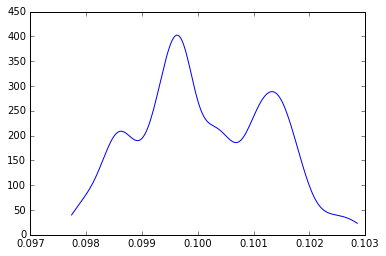

In [27]:
from scipy.stats import gaussian_kde
p1_kde = gaussian_kde(p1_normal)
p1_xs = np.linspace(min(p1_normal),max(p1_normal),200)
plt.plot(p1_xs,p1_kde(p1_xs))
plt.show()

This is not a normal distribution.

In [40]:
print('P1 ideal value is 0.083, estimated average is {0} and std is {1} '.format(np.mean(p1_normal),np.std(p1_normal)))
print('P2 ideal value is 4.867, estimated average is {0} and std is {1} '.format(np.mean(p2_normal),np.std(p2_normal)))
print('P2 ideal value is 29.917, estimated average is {0} and std is {1} '.format(np.mean(p3_normal),np.std(p3_normal)))

P1 ideal value is 0.083, estimated average is 0.10010323590674661 and std is 0.0011554432240345066 
P2 ideal value is 4.867, estimated average is 13.179198355680096 and std is 0.32428973408429096 
P2 ideal value is 29.917, estimated average is 28.43778449604541 and std is 0.2645495976967904 


Create a normal range for the parameters, using mean -+ number of standard deviations based on tolerance. High tolerance means the fault detection process is less sensitive but also produces less false positives. Since the distribution of the parameters are multimodal, a high tolerance is used here.

In [34]:
#define tolerance of parameters
tolerance = 4
p1_upper = np.full(iterations,np.mean(p1_normal)+tolerance*np.std(p1_normal))
p1_lower = np.full(iterations,np.mean(p1_normal)-tolerance*np.std(p1_normal))
p2_upper = np.full(iterations,np.mean(p2_normal)+tolerance*np.std(p2_normal))
p2_lower = np.full(iterations,np.mean(p2_normal)-tolerance*np.std(p2_normal))
p3_upper = np.full(iterations,np.mean(p3_normal)+tolerance*np.std(p3_normal))
p3_lower = np.full(iterations,np.mean(p3_normal)-tolerance*np.std(p3_normal))

## Biased Zone CO2 Sensor

Then introduce a large measurement drifting bias to the CO2 sensor. It is assumed that the zone CO2 sensor drifts to $-100ppm$ in a month, and the bias stays constant for the rest of the simulation.

In [16]:
drift_length = 31*24*12
bias_length = length-drift_length
zoneco2_bias = np.append(np.linspace(0,-100,drift_length),np.linspace(-100,-100,bias_length))

In [17]:
#create a new EKF filter
state_estimates = np.matrix([[data["ZoneCO2"][0]],
                             [np.mean(p1_normal)],
                             [np.mean(p2_normal)],
                             [np.mean(p3_normal)]])
co2_ekf = EKF.ExtendedKalmanFilter(fun, X, U, P, Q, H, R, state_estimates)

predicted_bias = []
actual_bias = []
measured_bias = []
estimates_bias = []
p1_bias = []
p2_bias = []
p3_bias = []

In [18]:
for i in range(1, iterations):
    #generate control vector
    C_out = 420
    C_supply = data["SupplyCO2"][i-1] + supplyCO2_noise[i-1]
    Q_supply = data["SupplyFlow"][i-1] + supplyflow_noise[i-1]
    OCC = data["OCCU"][i-1]
    controls = np.matrix([[C_out], [C_supply], [Q_supply], [OCC]])

    #prediction
    co2_ekf.predict(controls)
    predicted_bias.append(co2_ekf.X_values[0,0])
    estimates_bias.append(co2_ekf.X_values.T.reshape(-1,).tolist())
    p1_bias.append(co2_ekf.X_values[1,0])
    p2_bias.append(co2_ekf.X_values[2,0])
    p3_bias.append(co2_ekf.X_values[3,0])

    #update
    meas = data["ZoneCO2"][i] + zoneCO2_noise[i] + zoneco2_bias[i]
    actual_bias.append(data["ZoneCO2"][i])
    measured_bias.append(meas)
    co2_ekf.update(np.matrix([[meas],[0],[0],[0]]))

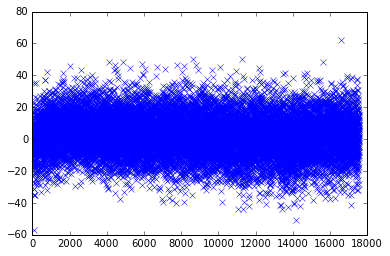

In [35]:
residues_bias = list(map(operator.sub, predicted_bias, measured_bias))
plt.plot(residues_bias, 'x')
plt.show()

The bias has been slightly increased due to the introduced instability in the system.

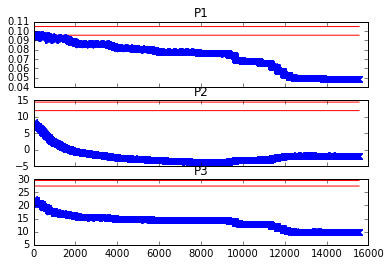

In [36]:
plot_start = 7*24*12
plot_end = iterations
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(p1_upper[plot_start:plot_end],'r')
axarr[0].plot(p1_lower[plot_start:plot_end],'r')
axarr[0].plot(p1_bias[plot_start:plot_end],'x')
axarr[0].set_title('P1')
axarr[1].plot(p2_upper[plot_start:plot_end],'r')
axarr[1].plot(p2_lower[plot_start:plot_end],'r')
axarr[1].plot(p2_bias[plot_start:plot_end],'x')
axarr[1].set_title('P2')
axarr[2].plot(p3_upper[plot_start:plot_end],'r')
axarr[2].plot(p3_lower[plot_start:plot_end],'r')
axarr[2].plot(p3_bias[plot_start:plot_end],'x')
axarr[2].set_title('P3')

Because the zone sensor understimates the prediction output, this makes all parameters become less sensitive to the inputs, thus making them lower than normal values. The drifting change of the parameters also indicates a drifting sensor error.

## Biased Supply CO2 Sensor

Next we study the effect of a biased input sensor. The same drifting sensor error is used, but for the supply CO2 sensor and with a smaller magnitude and opposite direction of $+50ppm$.

In [45]:
state_estimates = np.matrix([[data["ZoneCO2"][0]],
                             [np.mean(p1_normal)],
                             [np.mean(p2_normal)],
                             [np.mean(p3_normal)]])
co2_ekf = EKF.ExtendedKalmanFilter(fun, X, U, P, Q, H, R, state_estimates)

drift_length = 31*24*12
bias_length = length-drift_length
supplyco2_bias = np.append(np.linspace(0,50,drift_length),np.linspace(50,50,bias_length))
print(supplyco2_bias)

predicted_supplybias = []
actual_supplybias = []
measured_supplybias = []
estimates_supplybias = []
p1_supplybias = []
p2_supplybias = []
p3_supplybias = []

[  0.00000000e+00   5.60098577e-03   1.12019715e-02 ...,   5.00000000e+01
   5.00000000e+01   5.00000000e+01]


In [46]:
for i in range(1, iterations):
    #generate control vector
    C_out = 420
    C_supply = data["SupplyCO2"][i-1] + supplyCO2_noise[i-1] + supplyco2_bias[i]
    Q_supply = data["SupplyFlow"][i-1] + supplyflow_noise[i-1]
    OCC = data["OCCU"][i-1]
    controls = np.matrix([[C_out], [C_supply], [Q_supply], [OCC]])

    #prediction
    co2_ekf.predict(controls)
    predicted_supplybias.append(co2_ekf.X_values[0,0])
    estimates_supplybias.append(co2_ekf.X_values.T.reshape(-1,).tolist())
    p1_supplybias.append(co2_ekf.X_values[1,0])
    p2_supplybias.append(co2_ekf.X_values[2,0])
    p3_supplybias.append(co2_ekf.X_values[3,0])

    #update
    meas = data["ZoneCO2"][i] + zoneCO2_noise[i]
    actual_supplybias.append(data["ZoneCO2"][i])
    measured_supplybias.append(meas)
    co2_ekf.update(np.matrix([[meas],[0],[0],[0]]))

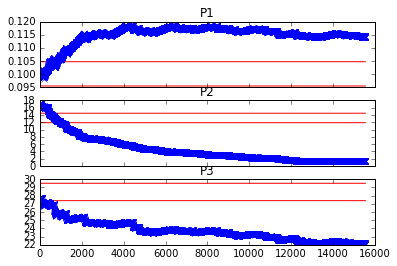

In [47]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(p1_upper[plot_start:plot_end],'r')
axarr[0].plot(p1_lower[plot_start:plot_end],'r')
axarr[0].plot(p1_supplybias[plot_start:plot_end],'x')
axarr[0].set_title('P1')
axarr[1].plot(p2_upper[plot_start:plot_end],'r')
axarr[1].plot(p2_lower[plot_start:plot_end],'r')
axarr[1].plot(p2_supplybias[plot_start:plot_end],'x')
axarr[1].set_title('P2')
axarr[2].plot(p3_upper[plot_start:plot_end],'r')
axarr[2].plot(p3_lower[plot_start:plot_end],'r')
axarr[2].plot(p3_supplybias[plot_start:plot_end],'x')
axarr[2].set_title('P3')

All three parameters changed, but the directly affected parameter - $p_2$ is the most affected. And $p2$ becomes smaller because the related input is higher than the actual input values.

## Increased Infiltration

Study the effect of changed physical parameters. The air change rate of the zone is increased to 1.5 ACH instead of 1.

In [54]:
data_infiltration = pd.read_csv('data/EP_CO2_Infiltration.csv')

In [55]:
state_estimates = np.matrix([[data_infiltration["ZoneCO2"][0]],
                             [np.mean(p1_normal)],
                             [np.mean(p2_normal)],
                             [np.mean(p3_normal)]])
co2_ekf = EKF.ExtendedKalmanFilter(fun, X, U, P, Q, H, R, state_estimates)

predicted_infiltration = []
actual_infiltration = []
measured_infiltration = []
estimates_infiltration = []
p1_infiltration = []
p2_infiltration = []
p3_infiltration = []

In [56]:
for i in range(1, iterations):
    #generate control vector
    C_out = 420
    C_supply = data_infiltration["SupplyCO2"][i-1] + supplyCO2_noise[i-1]
    Q_supply = data_infiltration["SupplyFlow"][i-1] + supplyflow_noise[i-1]
    OCC = data_infiltration["OCCU"][i-1]
    controls = np.matrix([[C_out], [C_supply], [Q_supply], [OCC]])

    #prediction
    co2_ekf.predict(controls)
    predicted_infiltration.append(co2_ekf.X_values[0,0])
    estimates_infiltration.append(co2_ekf.X_values.T.reshape(-1,).tolist())
    p1_infiltration.append(co2_ekf.X_values[1,0])
    p2_infiltration.append(co2_ekf.X_values[2,0])
    p3_infiltration.append(co2_ekf.X_values[3,0])

    #update
    meas = data_infiltration["ZoneCO2"][i] + zoneCO2_noise[i]
    actual_infiltration.append(data["ZoneCO2"][i])
    measured_infiltration.append(meas)
    co2_ekf.update(np.matrix([[meas],[0],[0],[0]]))

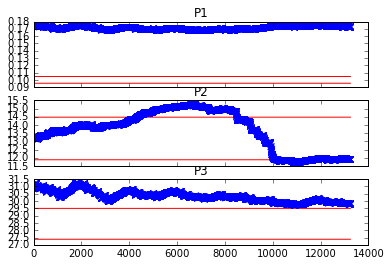

In [57]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(p1_upper[plot_start:plot_end],'r')
axarr[0].plot(p1_lower[plot_start:plot_end],'r')
axarr[0].plot(p1_infiltration[plot_start:plot_end],'x')
axarr[0].set_title('P1')
axarr[1].plot(p2_upper[plot_start:plot_end],'r')
axarr[1].plot(p2_lower[plot_start:plot_end],'r')
axarr[1].plot(p2_infiltration[plot_start:plot_end],'x')
axarr[1].set_title('P2')
axarr[2].plot(p3_upper[plot_start:plot_end],'r')
axarr[2].plot(p3_lower[plot_start:plot_end],'r')
axarr[2].plot(p3_infiltration[plot_start:plot_end],'x')
axarr[2].set_title('P3')

Again the related parameter P1 has the most significant change, and other two paramters are affected but by a small degree, due to the way EKF works. P1 is increased by around $60\%$ and correlates to the $50\%$ increase in the zone infiltration rate.